In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px


from concurrent.futures import ThreadPoolExecutor
import random

from sklearn.preprocessing import MinMaxScaler, StandardScaler #only used MinMAx and seems to work better
from sklearn.decomposition import PCA # I tried PCA but didn't spend much time on it. The reduced version had no visualizaiton benefits
from sklearn.manifold import TSNE

In [ ]:
root_dir = "~/Documents/Data/Birds/2021/"

spectrograms = []
labels = []

locations = ["BRY", "CAL", "FIO", "HAR", "KEA", "LAW", "LIF", "MCK", "PEN", "SYL", "WAT"]

def process_file(args):
    spec_path, label_row = args
    spec_data = pd.read_csv(spec_path, header=None).values 
    return spec_data, label_row[1:].values  

for location in locations:
    location_dir = os.path.join(root_dir, location)
    spec_dir = os.path.join(location_dir, "SPEC")
    labels_file = os.path.join(location_dir, "train_labels.csv")
    
    labels_df = pd.read_csv(labels_file)
    
    tasks = []
    for _, row in labels_df.iterrows():
        fname = row['fname'].replace(".mp3", ".csv")  
        spec_path = os.path.join(spec_dir, fname)
        tasks.append((spec_path, row)) 

    
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(process_file, tasks))
    

    for spec_data, label_data in results:
        spectrograms.append(spec_data)
        labels.append(label_data)

spectrograms = np.array(spectrograms)
labels = np.array(labels)

print(f"Spectrograms shape: {spectrograms.shape}") 
print(f"Labels shape: {labels.shape}") 

In [ ]:
np.save("spectrograms.npy", spectrograms)
np.save("labels.npy", labels)

# Start from here if you downloaded my npy files

In [2]:
spectrograms_path = os.path.expanduser("~/Documents/Code/Bird Classification/spectrograms.npy")
labels_path = os.path.expanduser("~/Documents/Code/Bird Classification/labels.npy")
root_dir = "~/Documents/Data/Birds/2021/"

spectrograms = np.load(spectrograms_path)
labels = np.load(labels_path,allow_pickle=True)

In [3]:
print(f"Spectrograms shape: {spectrograms.shape}") 
print(f"Labels shape: {labels.shape}")

Spectrograms shape: (2714, 258, 2813)
Labels shape: (2714, 10)


In [4]:
#Norm

num_samples, num_freqs, num_times = spectrograms.shape
spectrograms_flat = spectrograms.reshape(num_samples, -1)


scaler = MinMaxScaler()
spectrograms_normalized = scaler.fit_transform(spectrograms_flat)

spectrograms_normalized = spectrograms_normalized.reshape(num_samples, num_freqs, num_times)

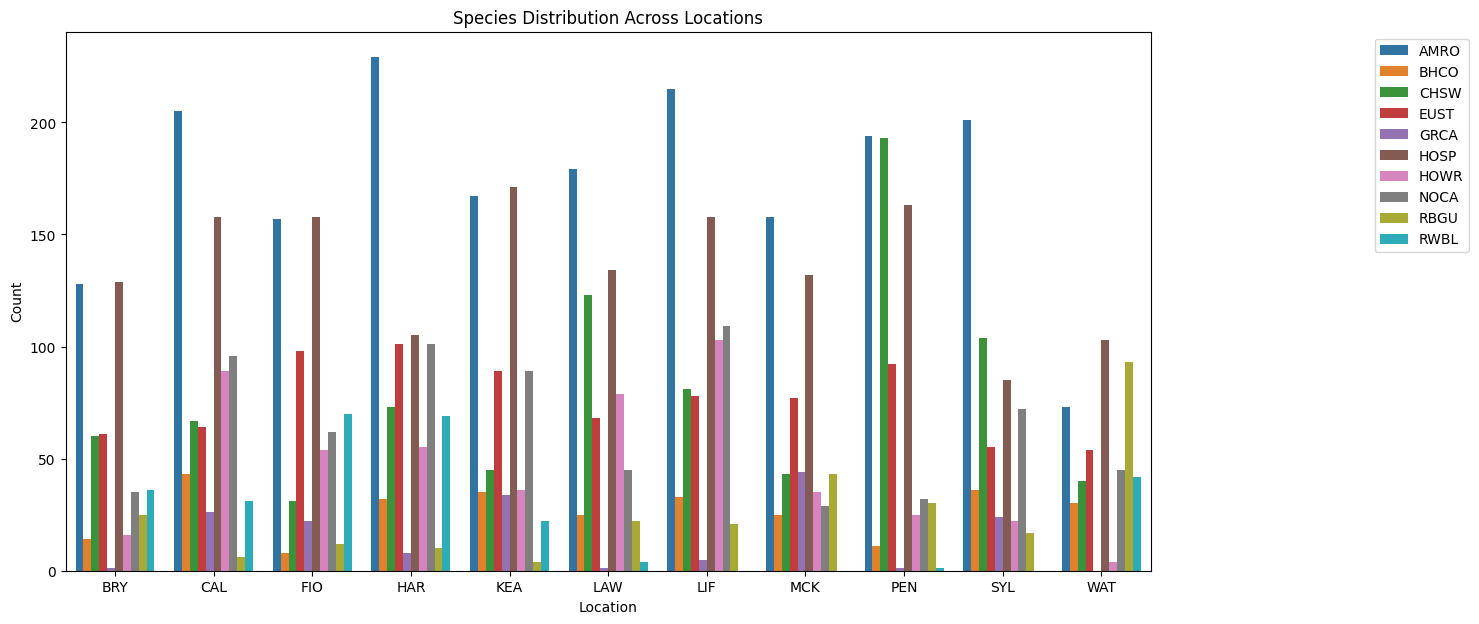

In [5]:

locations = ["BRY", "CAL", "FIO", "HAR", "KEA", "LAW", "LIF", "MCK", "PEN", "SYL", "WAT"]

species_labels = ["AMRO", "BHCO", "CHSW", "EUST", "GRCA", "HOSP", "HOWR", "NOCA", "RBGU", "RWBL"]
location_species_data = []


for location in locations:
    labels_file = os.path.join(root_dir, location, "train_labels.csv")
    labels_df = pd.read_csv(labels_file)
    location_species_sum = labels_df[species_labels].sum(axis=0)
    location_species_sum["Location"] = location
    location_species_data.append(location_species_sum)

location_species_df = pd.DataFrame(location_species_data)

melted_df = location_species_df.melt(id_vars=["Location"], var_name="Species", value_name="Count")

plt.figure(figsize=(14, 7))
sns.barplot(data=melted_df, x="Location", y="Count", hue="Species")
plt.title("Species Distribution Across Locations")
plt.ylabel("Count")
plt.xlabel("Location")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()

In [6]:
spectrograms_fully_normalized = []

for spec in spectrograms_normalized:
    spec_shifted = spec - spec.min()

    spec_log = np.log1p(spec_shifted)

    spec_normalized = (spec_log - spec_log.min()) / (spec_log.max() - spec_log.min())

    spectrograms_fully_normalized.append(spec_normalized)


spectrograms_fully_normalized = np.array(spectrograms_fully_normalized)

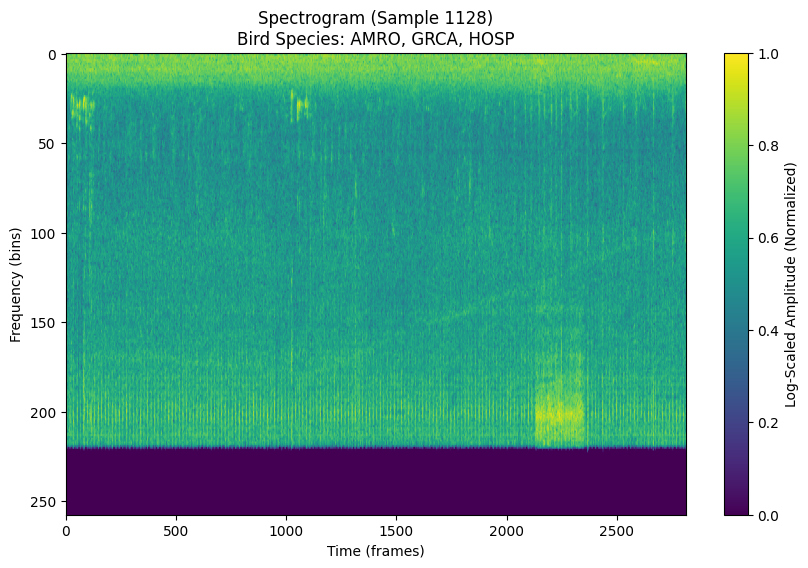

In [33]:
# random_idx = random.randint(0, len(spectrograms_fully_normalized) - 1)
spec = spectrograms_fully_normalized[random_idx]
label = labels[random_idx]

present_species = [species_labels[i] for i in range(len(species_labels)) if label[i] == 1]

plt.figure(figsize=(10, 6))
plt.imshow(spec, aspect='auto', cmap='viridis')
plt.colorbar(label="Log-Scaled Amplitude (Normalized)")
plt.title(f"Spectrogram (Sample {random_idx})\nBird Species: {', '.join(present_species)}")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency (bins)")
plt.show()

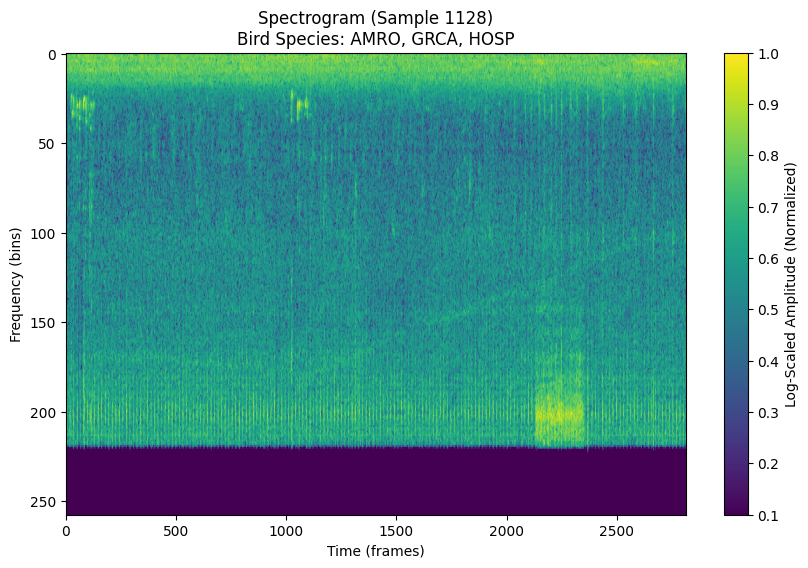

In [32]:
random_idx = random.randint(0, len(spectrograms_fully_normalized) - 1)
spec = spectrograms_fully_normalized[random_idx]
label = labels[random_idx]

spec_visual = np.where(spec > 0.4, spec, 0.1)

present_species = [species_labels[i] for i in range(len(species_labels)) if label[i] == 1]

plt.figure(figsize=(10, 6))
plt.imshow(spec_visual, aspect='auto', cmap='viridis')
plt.colorbar(label="Log-Scaled Amplitude (Normalized)")
plt.title(f"Spectrogram (Sample {random_idx})\nBird Species: {', '.join(present_species)}")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency (bins)")
plt.show()

In [28]:
species_summary = {species: [] for species in species_labels}
species_summary["Location"] = []

for location in locations:
    labels_file = os.path.join(root_dir, location, "train_labels.csv")
    labels_df = pd.read_csv(labels_file)
    
    species_counts = labels_df[species_labels].sum(axis=0).tolist()
    
    for i, species in enumerate(species_labels):
        species_summary[species].append(species_counts[i])
    species_summary["Location"].append(location)

species_summary_df = pd.DataFrame(species_summary)

overall_counts = species_summary_df[species_labels].sum(axis=0).tolist()  
overall_row = {"Location": "Overall"} 
overall_row.update({species: count for species, count in zip(species_labels, overall_counts)}) 
species_summary_df = pd.concat([species_summary_df, pd.DataFrame([overall_row])], ignore_index=True)
species_summary_df

,AMRO,BHCO,CHSW,EUST,GRCA,HOSP,HOWR,NOCA,RBGU,RWBL,Location
0,128,14,60,61,1,129,16,35,25,36,BRY
1,205,43,67,64,26,158,89,96,6,31,CAL
2,157,8,31,98,22,158,54,62,12,70,FIO
3,229,32,73,101,8,105,55,101,10,69,HAR
4,167,35,45,89,34,171,36,89,4,22,KEA
5,179,25,123,68,1,134,79,45,22,4,LAW
6,215,33,81,78,5,158,103,109,21,0,LIF
7,158,25,43,77,44,132,35,29,43,0,MCK
8,194,11,193,92,1,163,25,32,30,1,PEN
9,201,36,104,55,24,85,22,72,17,0,SYL


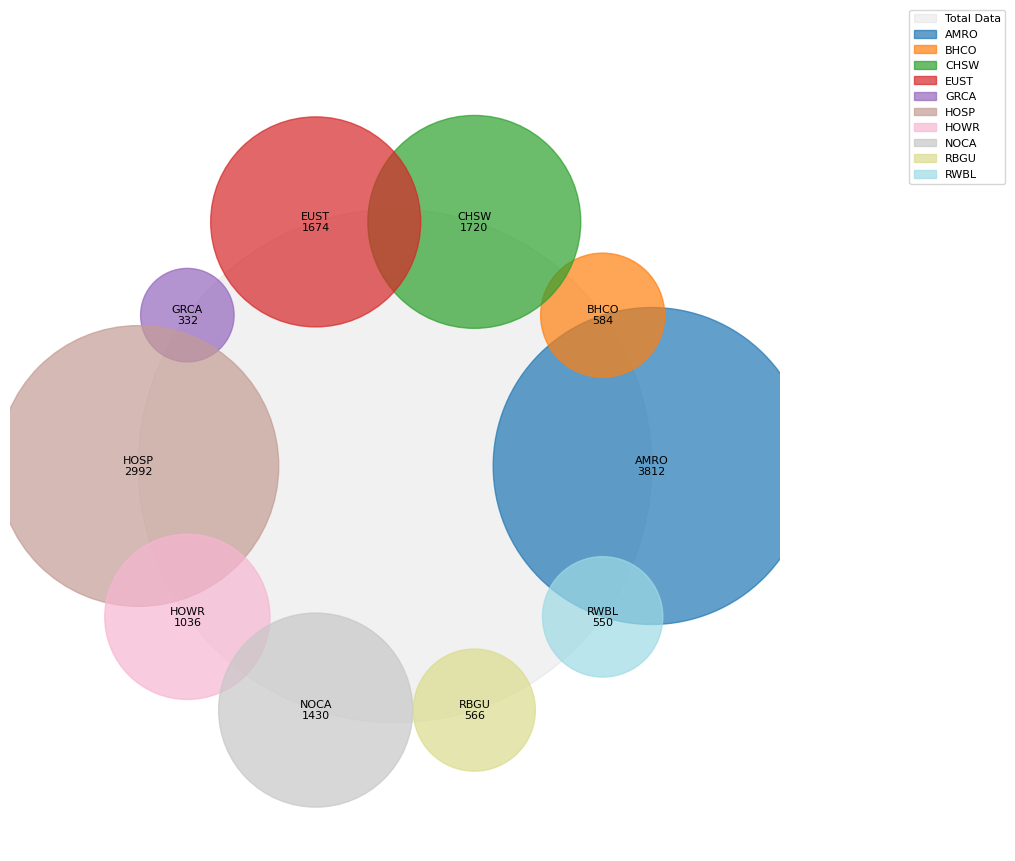

In [16]:
species_columns = species_summary_df.columns[:-1]  # no 'Location'
species_sums = species_summary_df[species_columns].sum()  #  bird type count 
colors = plt.cm.tab20(np.linspace(0, 1, len(species_columns)))  

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

main_circle = plt.Circle((0, 0), 2, color='lightgrey', alpha=0.3, label='Total Data')
ax.add_artist(main_circle)

for species, count, color in zip(species_columns, species_sums, colors):
    radius = np.sqrt(count) / 50 
    angle = list(species_columns).index(species) * (2 * np.pi / len(species_columns))
    x = np.cos(angle) * 2
    y = np.sin(angle) * 2
    small_circle = plt.Circle((x, y), radius, color=color, alpha=0.7, label=species)
    ax.add_artist(small_circle)
    ax.text(x, y, f"{species}\n{count}", ha='center', va='center', fontsize=8)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.legend(loc='upper right', fontsize=8, bbox_to_anchor=(1.3, 1.1))
plt.show()
